AUC HO: 0.8977999999999999
AUC MCMC: 0.9219


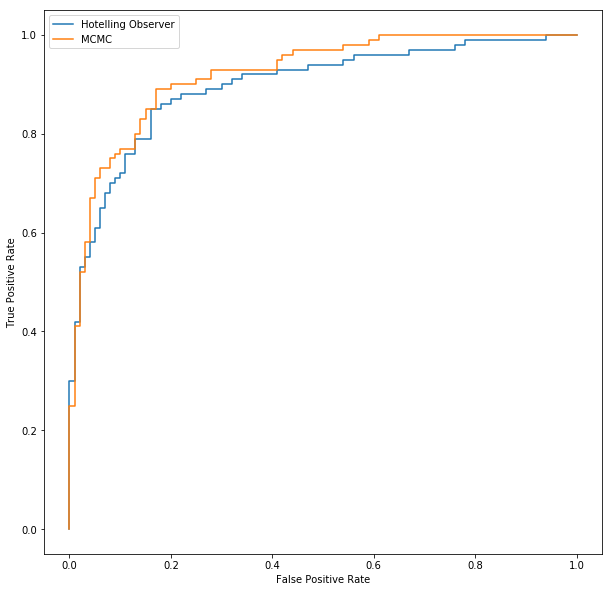

In [1]:
%matplotlib inline

import pickle
from sklearn.metrics import roc_auc_score as ras
from sklearn.metrics import roc_curve as rc
import scipy.ndimage as snd
import matplotlib.pyplot as plt
import numpy as np
from mcmc_lumpy import *

# load mcmc results
with open('ratios.pkl','rb') as f:
    lr, phi_set = pickle.load(f)

# Get the imagess for each of the phi sets
g = []
backgrounds = np.zeros((64,64,200))
for i,phi in enumerate(phi_set):
    g.append(phi.grab_g().ravel())
    theta = phi.grab_chain(real=False)[0]
    b, _, _ = create_lumpy_background(pos=theta)
    backgrounds[:,:,i] = b

# Calculate HO results for each background
# with signal 0.1 and noise 0.01
ho = []
obj_dim1 = [28, 33]
obj_dim2 = [29, 32]
signal = np.zeros((64, 64))
signal[obj_dim1[0]:obj_dim1[1], obj_dim2[0]:obj_dim2[1]] = 0.1
signal[obj_dim2[0]:obj_dim2[1], obj_dim1[0]:obj_dim1[1]] = 0.1
signal = snd.filters.gaussian_filter(signal, 2).ravel()

# Calculate covariance matrix
N_inv = np.eye(64**2)*(1/0.01)
W = backgrounds - np.repeat(np.mean(backgrounds, axis=2)[:, :, np.newaxis], 100*2, axis=2)
W = np.reshape(W, (64**2, -1))
NsNs = np.linalg.inv(np.eye(2*100)+np.matmul(W.transpose(), np.matmul(N_inv, W)))
K_inv = N_inv - np.matmul(N_inv, np.matmul(W, np.matmul(NsNs, np.matmul(W.transpose(), N_inv))))
for img in g:
    ho.append(np.dot(signal, np.matmul(K_inv, img)))
print('AUC HO: {}'.format(ras(100*[1,0],ho)))
print('AUC MCMC: {}'.format(ras(100*[1,0],lr)))
fpr_ho, tpr_ho, _ = rc(100*[1,0], ho)
fpr_mcmc, tpr_mcmc, _ = rc(100*[1,0], lr)
plt.figure(figsize=(10,10))
plt.plot(fpr_ho, tpr_ho, label='Hotelling Observer')
plt.plot(fpr_mcmc, tpr_mcmc, label='MCMC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()